# **1 Introduction/Project Specs**
## **1.1 By: Dylan Hicks**

## **1.2 Project Motivation**
Imagine you are holding a ten stock portfolio that looks safe on average, until one bad day wipes out weeks of gains. This project asks a simple question: how can we choose portfolio weights that explicitly control those worst case losses, not just the average return? Many simple portfolio optimization projects focus only on average returns, ignoring
significant downside losses. In problem three of homework five, we had to find the best
combination of investments given specific constraints, but we only considered expected return,
not risk. This project will build an equity portfolio that controls tail loss using Conditional
Value-at-Risk (CVaR) and expected losses in an objective together. The scope of the project will remain realistic, with basic position and sector limits. The decision is the allocation weight for each stock, and the goal is to find the
weights that minimize the specified objective. As specified by the professor, section 3 of the project will add a rebalance option at certain point in the timeline. This extension adds realism by allowing one planned rebalance, which lets us measure how limited trading flexibility changes tail risk and costs.

## **1.3 Description of the Project**
This notebook builds a CVaR (Conditional Value-at-Risk) portfolio optimizer with one planned rebalance, per-name and sector caps, and proportional trading costs. You set tickers and risk/return weights, download prices, compute returns, and run two models: a baseline (no rebalance) and a one-rebalance case. Outputs include weights, expected return, VaR/CVaR (tail-loss metrics), turnover, binding caps, and a simple frontier for the return–tail-risk trade-off. The workflow reruns from a clean kernel via a parameter cell.

* CVaR at confidence α (e.g., 95%) is the average loss in the worst (1–α)% of scenarios, explicit tail risk, not just volatility.
* VaR is the loss threshold exceeded (1–α)% of the time; CVaR averages losses beyond that threshold.
* The models pick long-only weights with per-name and sector caps; baseline minimizes a mean–CVaR loss trade-off, and the rebalance case adds trading, costs, and a scheduled rebalance.
* Outputs: weights, expected return, VaR, CVaR, turnover (for rebalance), binding caps, and a return loss plot showing the return–tail-risk balance.

## **1.4 Loading in the data**
The data comes from publicly available adjusted close prices downloaded via yfinance. For reproducibility, the pipeline pulls a user‑specified list of tickers over a chosen look back window (either a set number of years or ending at a user‑supplied date), computes daily log returns, and caches both prices and returns to CSV under ../Data/. Sector labels are loaded from a provided sectors.csv aligned to the same tickers. When caching is enabled and matching files exist, the loader will reuse the stored CSVs instead of re‑downloading, keeping the workflow consistent across runs. 

**Important Note**: For this specific notebook, the end date is specified as 2025-12-08. This means that the numbers calculated from the model are based on this specific time frame, so please wait until you have read everything in the notebook to change it. This goes for all specified parameters as well. 

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = Path("../Data") # edit this line to place Data folder where you want
DATA_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
params = {
    "tickers": ["AAPL","MSFT","NVDA","GOOGL","META","AMZN","JPM","XOM","CVX","UNH",],
    "years": 3,
    "alpha": 0.95,
    "name_cap": 0.1,
    "sector_cap": 0.5,
    "buy_cost": 0.002,
    "sell_cost": 0.002,
    "end_date": "2025-12-08", # YYYY-MM-DD Format
    "rebalance_day": "midpoint",      # or an integer index
    "return_target": "equal_weight_mean",  # or a float like 0.0003
    "lambda_cvar": 0.8,      # weight on CVaR (as a loss) in the objective 
    "use_cached": True,
}

In [3]:
def load_prices_and_returns(tickers, years, use_cached=True, end_date=None):
    prices_path = DATA_DIR / "prices.csv"
    returns_path = DATA_DIR / "returns.csv"

    
    if end_date is None and use_cached and prices_path.exists() and returns_path.exists():
        px = pd.read_csv(prices_path, index_col=0, parse_dates=True)
        ret = pd.read_csv(returns_path, index_col=0, parse_dates=True)
        return px, ret, []

    if end_date is not None:
        end = pd.Timestamp(end_date).normalize()
        start = end - pd.DateOffset(years=years)
        px = yf.download(
            tickers,
            start=start,
            end=end + pd.Timedelta(days=1),  
            auto_adjust=True,
            progress=False,
        )["Close"]
    else:
        px = yf.download(tickers, period=f"{years}y", auto_adjust=True, progress=False)["Close"]

   
    if isinstance(px, pd.Series):
        px = px.to_frame()

    dropped = [c for c in tickers if px[c].isna().any()]
    px = px.dropna(how="any")
    ret = np.log(px / px.shift(1)).dropna()

    
    px.to_csv(prices_path)
    ret.to_csv(returns_path)

    return px, ret, dropped


In [4]:
def ensure_sectors(tickers, sectors_path=DATA_DIR / "sectors.csv"):
    sectors_path = Path(sectors_path)
    sectors_path.parent.mkdir(parents=True, exist_ok=True)

    
    if sectors_path.exists():
        df = pd.read_csv(sectors_path)
    else:
        df = pd.DataFrame(columns=["ticker", "sector"])

    
    known = dict(zip(df["ticker"], df["sector"]))
    missing = [t for t in tickers if (t not in known) or pd.isna(known[t])]

    fetched = []
    for t in missing:
        sec = None
        try:
            finfo = yf.Ticker(t).fast_info
            sec = getattr(finfo, "sector", None)
            if sec is None:
                info = yf.Ticker(t).info
                sec = info.get("sector")
        except Exception as e:
            print(f"Failed to fetch sector for {t}: {e}")
        if sec:
            fetched.append((t, sec))

    if fetched:
        df = pd.concat(
            [df, pd.DataFrame(fetched, columns=["ticker", "sector"])],
            ignore_index=True,
        ).drop_duplicates(subset="ticker", keep="last")
        df.to_csv(sectors_path, index=False)
        print(f"Wrote {len(fetched)} sector rows to {sectors_path}")
    else:
        print("No new sectors fetched.")

    sectors = df.set_index("ticker").reindex(tickers)["sector"]
    missing_after = sectors[sectors.isna()].index.tolist()
    if missing_after:
        raise ValueError(f"Missing sector labels for: {missing_after}")
    return sectors


In [5]:
tickers = params["tickers"]
px, ret, dropped = load_prices_and_returns(tickers, params["years"], params["use_cached"], params["end_date"])
sectors = ensure_sectors(params["tickers"])

summary = {
    "N": ret.shape[0],
    "S": ret.shape[1],
    "start_date": ret.index.min().date().isoformat(),
    "end_date": ret.index.max().date().isoformat(),
    "dropped": dropped,
    "avg_mean": ret.mean().mean(),
    "avg_std": ret.std().mean(),
    "avg_corr": ret.corr().replace(1.0, np.nan).stack().mean(),
}

display(summary)

sectors = pd.read_csv(DATA_DIR / "sectors.csv").set_index("ticker")["sector"]
missing = [t for t in tickers if t not in sectors.index]
print("Missing sector labels:", missing)

No new sectors fetched.


{'N': 751,
 'S': 10,
 'start_date': '2022-12-09',
 'end_date': '2025-12-08',
 'dropped': [],
 'avg_mean': np.float64(0.0011072308037992367),
 'avg_std': np.float64(0.019063594460417835),
 'avg_corr': np.float64(0.27405628979645286)}

Missing sector labels: []


**Important Note**: Uncomment and run cell below if loading in the data did not work on your computer. This gives the same returns as the 3-year period with end date at 2025-12-08. 

In [6]:
# px = pd.read_csv("../Backup Data/prices.csv")
# tickers = params["tickers"]

# # If using backup CSVs
# ret = pd.read_csv("../Backup Data/returns.csv", index_col=0, parse_dates=True)
# # Keep only your tickers and coerce to numeric
# ret = ret[tickers].apply(pd.to_numeric, errors="coerce")
# ret = ret.dropna(how="any")

# sectors = pd.read_csv("../Backup Data/sectors.csv", index_col=0)["sector"].reindex(tickers)


## **1.5 Exploring the data**
The EDA is kept simple: load the daily log returns and produce quick sanity checks and a tail‑risk visual. We print summary statistics (mean, std) to confirm the data looks reasonable, then plot a loss histogram (negative returns), for one stock, with markers for the mean loss, 95% VaR, and 95% CVaR so you can see where the worst days sit relative to the bulk of the distribution.

In [7]:
display(ret.describe().T[['mean','std']].head())

,mean,std
Ticker,,
AAPL,0.000908,0.016338
AMZN,0.001226,0.020251
CVX,-0.000038,0.014240
GOOGL,0.001619,0.019138
JPM,0.001249,0.014361


AAPL mean loss: -0.0009
AAPL VaR 95%:    0.0255
AAPL CVaR 95%:   0.0375
AAPL max loss:   0.0970


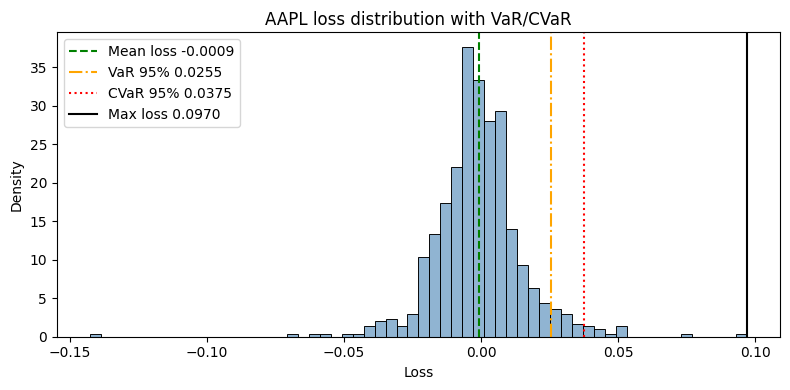

In [8]:
import numpy as np, matplotlib.pyplot as plt, seaborn as sns

ticker = "AAPL"  
losses = -ret[ticker].values           
var95 = np.quantile(losses, params["alpha"])
cvar95 = losses[losses >= var95].mean()
mean_loss = losses.mean()
max_loss = losses.max()

print(f"{ticker} mean loss: {mean_loss:.4f}")
print(f"{ticker} VaR 95%:    {var95:.4f}")
print(f"{ticker} CVaR 95%:   {cvar95:.4f}")
print(f"{ticker} max loss:   {max_loss:.4f}")

plt.figure(figsize=(8,4))
sns.histplot(losses, bins=60, stat="density", color="steelblue", alpha=0.6)
plt.axvline(mean_loss, color="green", linestyle="--", label=f"Mean loss {mean_loss:.4f}")
plt.axvline(var95, color="orange", linestyle="-.", label=f"VaR 95% {var95:.4f}")
plt.axvline(cvar95, color="red", linestyle=":", label=f"CVaR 95% {cvar95:.4f}")
plt.axvline(max_loss, color="black", linestyle="-", label=f"Max loss {max_loss:.4f}")
plt.xlabel("Loss")
plt.title(f"{ticker} loss distribution with VaR/CVaR")
plt.legend()
plt.tight_layout()
plt.show()


## **1.6 Deliverables**
* Rerunnable GAMSPy notebook (notebooks/00_CVaR_Portfolio.ipynb) that reads CSVs, builds the scenario matrix, and solves both models: baseline mean–CVaR (long-only, caps) and one-rebalance mean–CVaR with costs.

* Helper functions to change tickers/years/end_date, regenerate prices/returns, refresh sectors, and re-run models for reproducibility; backup CSV loader cell for offline fallback.

*  Figures: return–CVaR frontier (short sweep), weights by sector, VaR/CVaR histograms (baseline and rebalance), and comparison against equal-weight benchmark.

* Results: optimal weights (pre/post), buys/sells (rebalance), expected return, VaR, CVaR, objective value, turnover (rebalance), binding name/sector caps, model/solve status.

* Brief write-up in the notebook describing α, caps, costs, target return choice, model interpretations (baseline vs rebalance), and key takeaways.

## **1.7 Other points for me to consider**
* Data integrity: verify price/return alignment, no NAs after cleaning, sectors mapped for all tickers, and return units consistent (log vs simple). Cache the cleaned CSVs and note the date range used.

* Feasibility: check model_status/solve_status and that the return target is realistic under the given caps; if infeasible, lower the target or relax caps slightly.

* Computational cost: limit scenarios (shorter look back, weekly sampling, or random subsample), keep long-only and avoid integers/cardinality; cache downloads to skip refetching.

* Numerical stability: confirm CVaR tail count ≈ (1–α)*N, shortfalls nonnegative, and weights sum to 1; ensure loss sign conventions are consistent across baseline/rebalance.

* Outputs to report: weights (pre/post), buys/sells, expected return, VaR, CVaR, turnover, binding caps, model status. Plot VaR/CVaR histograms and sector weights for quick visual sanity checks.


# **2 Building the baseline model**
Here we will build the model and run two different test cases, one with equal weights, and one with unconstrained weights.

## **2.1 Description of approach used: Baseline CVaR (no rebalance)**

In this section, I turn the historical return scenarios into a simple optimization problem. The goal is to choose long only weights that keep the average loss reasonable while cutting down the worst 5 percent of days. I first set up the math for a no rebalance CVaR model, then solve it and compare the results to an equal weight portfolio.

**Math formulation** (N scenarios, S assets)

**Sets**

- Assets: $i \in I$ (tickers)  
- Scenarios: $s \in S$ (historical days)  
- Sectors: $k \in K$; membership $i \in I_k \subseteq I$ for each sector  

---

**Parameters**

- $r_{s,i}$: scenario return of asset $i$ in scenario $s$ (from `returns.csv`)  
- $\mu_i$: mean return of asset $i$ (column mean of $r$)  
- $p_s = 1 / |S|$: scenario probability (uniform)  
- $\alpha$: CVaR confidence level  
- $\bar r$: optional target expected return (set to $0$ if unused)  
- $\bar w_{\text{name}}$: per-name cap  
- $\bar w_{\text{sector}}$: per-sector cap (applied to each $k$)  
- $\lambda_{\text{mean}}, \lambda_{\text{cvar}}$: weights on expected loss and CVaR in the objective  

---

**Variables**

- $w_i \ge 0$: portfolio weight of asset $i$  
- $\nu \in \mathbb{R}$: VaR threshold (loss)  
- $u_s \ge 0$: shortfall in scenario $s$  

---

**Objective (loss-based mean–CVaR trade-off)**

Minimize weighted expected loss plus weighted tail loss:

$$
\min_{w,\nu,u}\ 
\lambda_{\text{mean}}\left(-\sum_{i\in I}\mu_i w_i\right)
+
\lambda_{\text{cvar}}\left(\nu + \frac{1}{1-\alpha}\sum_{s\in S} p_s\, u_s\right)
$$

---

**Constraints**

1. **Budget**

$$
\sum_{i\in I} w_i = 1
$$

2. **Optional return floor** (include only if $\bar r > 0$)

$$
\sum_{i\in I} \mu_i w_i \ge \bar r
$$

3. **Shortfall definition**  
   (loss in scenario $s$: $-\sum_{i\in I} r_{s,i} w_i$)

For all $s \in S$:

$$
u_s \ge -\sum_{i\in I} r_{s,i} w_i - \nu
$$

$$
u_s \ge 0
$$

4. **Name caps**

For all $i \in I$:

$$
w_i \le \bar w_{\text{name}}
$$

5. **Sector caps**

For all $k \in K$:

$$
\sum_{i\in I_k} w_i \le \bar w_{\text{sector}}
$$

---

**Interpretation**

$w$ is the long-only portfolio, $\nu$ is the VaR (loss) level, $u_s$ captures excess loss beyond VaR in each scenario, and the objective penalizes both average loss and tail loss, so lowering it moves you toward portfolios with smaller expected and tail losses.


In [9]:
import gamspy as gp, re, pandas as pd, numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def solve_baseline_mean_cvar(ret_df, sectors, params):
    """
    ret_df: DataFrame of returns (rows = scenarios, cols = tickers)
    sectors: Series mapping ticker -> sector
    params: dict with keys:
        alpha, lambda_cvar, name_cap, sector_cap,
        return_target (float or 'none'), solver (optional)
    """

    S = list(ret_df.columns)
    mu = ret_df.mean()
    N = ret_df.shape[0]
    alpha = params["alpha"]
    lambda_mean = 1 - params["lambda_cvar"]
    lambda_cvar = params["lambda_cvar"]
    
        
    if params["return_target"] == "equal_weight_mean":
        target_return = mu.mean()
    elif isinstance(params["return_target"], (float, int)):
        target_return = float(params["return_target"])
    elif params["return_target"] == "none":
        target_return = 0.0
    else:
        raise ValueError("Unsupported return_target")

    m = gp.Container(options=gp.Options(equation_listing_limit=10, relative_optimality_gap=0.01))
    i = gp.Set(m, name="i", records=S)
    s = gp.Set(m, name="s", records=range(N))

    R = gp.Parameter(m, name="R", domain=[s, i], records=ret_df.values)
    mu_param = gp.Parameter(m, name="mu", domain=[i], records=mu.values)

    w  = gp.Variable(m, name="w", domain=[i], type="Positive")
    nu = gp.Variable(m, name="nu", type="Free")
    u  = gp.Variable(m, name="u", domain=[s], type="Positive")

    budget = gp.Equation(m, name="budget")
    budget[:] = gp.Sum(i, w[i]) == 1

    ret_con = gp.Equation(m, name="ret_con")
    ret_con[:] = gp.Sum(i, mu_param[i] * w[i]) >= target_return

    cvar_cons = gp.Equation(m, name="cvar_cons", domain=[s])
    cvar_cons[s] = u[s] >= -gp.Sum(i, R[s, i] * w[i]) - nu  

    name_cap = gp.Equation(m, name="name_cap", domain=[i]); name_cap[i] = w[i] <= params["name_cap"]

    sector_cap_eqs = []
    if sectors is not None:
        for sector_name in sectors.unique():
            tickers_in_sector = [t for t in S if sectors.get(t) == sector_name]
            if not tickers_in_sector:
                continue
            safe = re.sub(r"[^A-Za-z0-9_]", "_", sector_name)
            mask_df = pd.DataFrame({"i": S, f"mask_{safe}": [1 if t in tickers_in_sector else 0 for t in S]})
            mask_param = gp.Parameter(m, name=f"mask_{safe}", domain=[i]); mask_param.setRecords(mask_df)
            cap = gp.Equation(m, name=f"cap_{safe}")
            cap[:] = gp.Sum(i, mask_param[i] * w[i]) <= params["sector_cap"]
            sector_cap_eqs.append(cap)

    cvar_term = nu + (1 / ((1 - alpha) * N)) * gp.Sum(s, u[s])
    mean_loss = -gp.Sum(i, mu_param[i] * w[i])  
    obj = lambda_mean * mean_loss + lambda_cvar * cvar_term

    model = gp.Model(m, "baseline_mean_cvar",
                     equations= m.getEquations(),
                     problem=gp.Problem.LP,
                     sense=gp.Sense.MIN,
                     objective=obj)

    model.solve()

    w_opt = w.records.set_index("i")["level"]
    nu_val = float(nu.records["level"].iloc[0])
    cvar_val = float(cvar_term.toValue())
    mean_ret_val = float((mu * w_opt).sum())
    mean_loss_val = -mean_ret_val
    obj_val = float(obj.toValue())

    binding_names = w_opt[w_opt >= params["name_cap"] - 1e-6].index.tolist()
    binding_sectors = []
    for eq in sector_cap_eqs:
        rec = eq.records
        if rec.empty:
            continue
        upper = rec["upper"].replace([np.inf, -np.inf], np.nan)
        slack = upper - rec["level"]
        if abs(slack.iloc[0]) < 1e-6:
            binding_sectors.append(eq.name)

    return {
        "model_status": model.status,
        "weights": w_opt,
        "mean_return": mean_ret_val,
        "mean_loss": mean_loss_val,
        "VaR": nu_val,
        "target_return": target_return, 
        "CVaR_loss": cvar_val,
        "objective": obj_val,
        "binding_names": binding_names,
        "binding_sectors": binding_sectors,
    }

def show_baseline_results(res, sectors=None, title="Baseline CVaR results"):
    w_full = res["weights"].rename_axis("ticker").reset_index(name="weight")
    w_plot = w_full

    display(w_plot[w_plot["weight"] > 1e-6])

    if sectors is not None:
        sector_totals = (
            res["weights"].rename("weight").to_frame()
            .join(sectors.rename("sector"), how="left")
            .groupby("sector").sum()
        )
        display(sector_totals)

    print(title)
    print(f"Model status: {res.get('model_status')}")
    print(f"Target return: {res.get('target_return'):.6f}")
    print(f"Expected return: {res.get('mean_return'):.6f}")
    print(f"Expected loss:   {res.get('mean_loss'):.6f}")
    print(f"VaR (nu):        {res.get('VaR'):.6f}")
    print(f"CVaR (loss):     {res.get('CVaR_loss'):.6f}")
    print(f"Objective:       {res.get('objective'):.6f}")
    print(f"Binding name caps:   {res.get('binding_names')}")
    print(f"Binding sector caps: {res.get('binding_sectors')}")

    plt.figure(figsize=(max(8, 0.25 * len(w_plot)), 4))
    sns.barplot(w_plot, x="ticker", y="weight", color="steelblue", alpha=0.7)
    plt.title(title)
    plt.ylabel("weight")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()




def show_portfolio_cvar_baseline(ret_df, res, alpha=0.95, title="Portfolio VaR/CVaR"):
    
    weights = res["weights"]
    w = weights.reindex(ret_df.columns).fillna(0).values
    losses = -(ret_df.values @ w)  

    var = res["VaR"]
    cvar = res["CVaR_loss"]
    obj = res["objective"]
    mean_loss = losses.mean()
    max_loss = losses.max()

    print(f"{title}")
    print(f"Objective Value: {obj:.6f}")
    print(f"Mean loss: {mean_loss:.6f}")
    print(f"VaR {alpha:.2f}: {var:.6f}")
    print(f"CVaR {alpha:.2f}: {cvar:.6f}")
    print(f"Max loss: {max_loss:.6f}")

    plt.figure(figsize=(8, 4))
    sns.histplot(losses, bins=60, stat="density", color="steelblue", alpha=0.6)
    plt.axvline(mean_loss, color="green", linestyle="--", label=f"Mean {mean_loss:.4f}")
    plt.axvline(var, color="orange", linestyle="-.", label=f"VaR {alpha:.2f} {var:.4f}")
    plt.axvline(cvar, color="red", linestyle=":", label=f"CVaR {alpha:.2f} {cvar:.4f}")
    plt.axvline(max_loss, color="black", linestyle="-", label=f"Max {max_loss:.4f}")
    plt.xlabel("Loss")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


## **2.2 Running and Testing the Model**
To run the baseline CVaR model, I feed the historical return matrix, sector labels, and the parameters from Section 1 into solve_baseline_mean_cvar. I keep the confidence level at α = 0.95, cap each name at 10 percent, and cap each sector at 50 percent so the optimized portfolio is comparable to equal weight and does not concentrate in a single stock or sector.

The solver returns optimal weights, along with the implied VaR and CVaR of the portfolio. I then compute summary statistics for both the equal weight and the optimized portfolio and plot their loss distributions. These results show how much tail risk reduction I get from the CVaR optimization, holding the overall average loss roughly constant.

,ticker,weight
0,AAPL,0.1
1,AMZN,0.1
2,CVX,0.1
3,GOOGL,0.1
4,JPM,0.1
5,META,0.1
6,MSFT,0.1
7,NVDA,0.1
8,UNH,0.1
9,XOM,0.1


,weight
sector,
Communication Services,0.2
Consumer Cyclical,0.1
Energy,0.2
Financial Services,0.1
Healthcare,0.1
Technology,0.3


Baseline CVaR results
Model status: ModelStatus.OptimalGlobal
Target return: 0.001107
Expected return: 0.001107
Expected loss:   -0.001107
VaR (nu):        0.016635
CVaR (loss):     0.025666
Objective:       0.020311
Binding name caps:   ['AAPL', 'AMZN', 'CVX', 'GOOGL', 'JPM', 'META', 'MSFT', 'NVDA', 'UNH', 'XOM']
Binding sector caps: []


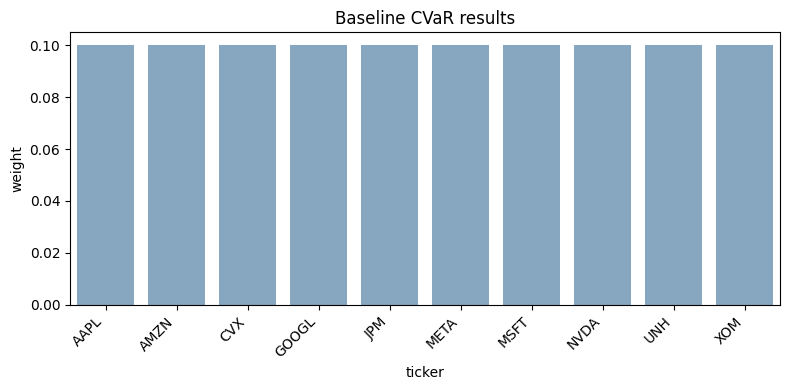

In [10]:
params["name_cap"] = 0.1
res = solve_baseline_mean_cvar(ret, sectors, params)
show_baseline_results(res, sectors)

Baseline portfolio VaR/CVaR
Objective Value: 0.020311
Mean loss: -0.001107
VaR 0.95: 0.016635
CVaR 0.95: 0.025666
Max loss: 0.058924


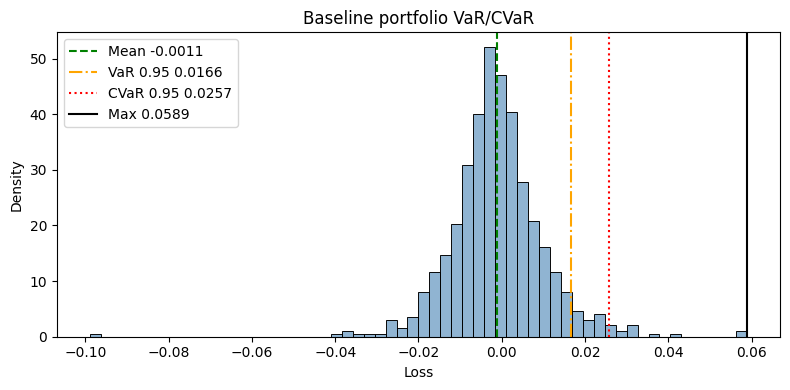

In [11]:
show_portfolio_cvar_baseline(ret, res, alpha=params["alpha"], title="Baseline portfolio VaR/CVaR")

,ticker,weight
0,AAPL,0.037075
3,GOOGL,0.117406
4,JPM,0.215934
5,META,0.122128
6,MSFT,0.144730
7,NVDA,0.054959
8,UNH,0.075872
9,XOM,0.231897


,weight
sector,
Communication Services,0.239533
Consumer Cyclical,0.000000
Energy,0.231897
Financial Services,0.215934
Healthcare,0.075872
Technology,0.236764


Baseline CVaR results
Model status: ModelStatus.OptimalGlobal
Target return: 0.001107
Expected return: 0.001107
Expected loss:   -0.001107
VaR (nu):        0.015487
CVaR (loss):     0.023202
Objective:       0.018340
Binding name caps:   []
Binding sector caps: []


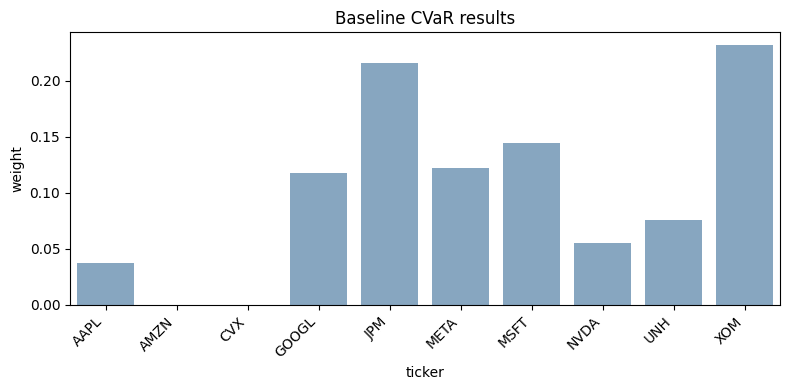

In [12]:
params["name_cap"] = 1
res = solve_baseline_mean_cvar(ret, sectors, params)
show_baseline_results(res, sectors)

Baseline portfolio VaR/CVaR
Objective Value: 0.018340
Mean loss: -0.001107
VaR 0.95: 0.015487
CVaR 0.95: 0.023202
Max loss: 0.058950


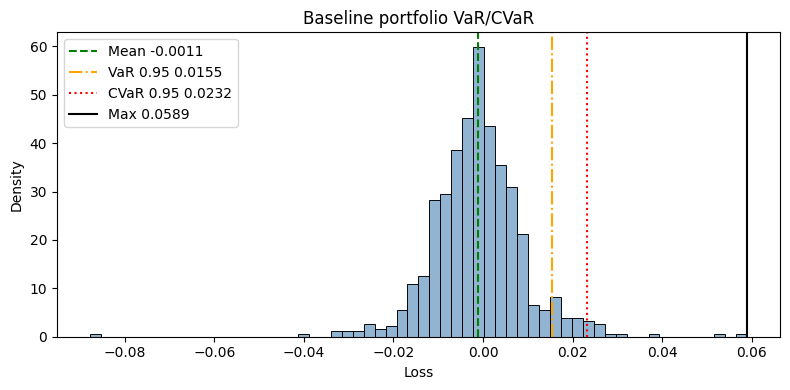

In [13]:
show_portfolio_cvar_baseline(ret, res, alpha=params["alpha"], title="Baseline portfolio VaR/CVaR")

## **2.3 Discussion on the results for this model**
**Equal weight vs optimized (baseline, no rebalance)**

* **Risk/tail**: The unconstrained CVaR model lowers tail risk. VaR drops from ~0.0166 to ~0.0155 and CVaR from ~0.0257 to ~0.0232, showing a smaller expected loss in the worst 5% of days.

* **Mean loss**: Both are around -0.001107, so average performance is similar; the gain is mainly in tail protection.

* **Allocation**: Equal-weight holds 10% in every name. The optimized baseline tilts toward JPM and XOM (~22% each) and away from AMZN/CVX (near zero), with modest weights in others. This concentration reflects which names help reduce tail losses under your historical scenarios.


* **Interpretation**: By relaxing equal-weight and allowing the CVaR optimizer to reallocate, you improve downside protection without sacrificing average return. The cost is less diversification across names, driven by the loss correlations and individual tail behavior in the data. The model gives helpful information about which stocks have less extreme worse days. AMZN/CVX get pushed out because their tails are more volatile in this sample, so a conservative trader should avoid those two stocks according to this model. Sector caps were did not bind here, so none could bind; in a larger universe, binding sector caps would flag sectors with milder tail losses.

# **3 Rebalance CVaR Model (single planned rebalance)**
## **3.1 Description of approach used: Builidng the Rebalance Model**

**Sets**
- Assets: $(i \in I)$
- Scenarios (days): $(s \in S)$
- Sectors: $(k \in K)$; membership $(i \in I_k \subseteq I)$

---

**Parameters**
- Returns $(r_{s,i})$ (from `returns.csv`)
- Mean returns: $(\mu_i^{\text{pre}}, \mu_i^{\text{post}})$
- Probabilities: $(p_s = 1/|S|)$
- Confidence $(\alpha)$
- Caps: $(\bar w_{\text{name}},\, \bar w_{\text{sector}})$
- Costs: $(c^{\text{buy}}, c^{\text{sell}})$
- Rebalance index $(k)$ (split $(S)$ into pre/post)
- Weights: $(\lambda_{\text{mean}},\, \lambda_{\text{cvar}})$
- $\bar r$: optional target expected return (set to $0$ if unused)

---

**Variables**
- Weights pre/post: $(w_{0,i} \ge 0,\; w_{1,i} \ge 0$)
- Trades: $(\text{buy}_i \ge 0,\; \text{sell}_i \ge 0)$
- Turnover: $(t_i \ge 0)$
- VaR threshold: $(\nu \in \mathbb{R})$
- Shortfalls: $(u_s \ge 0)$

---

**Constraints**
**Constraints**
- Budgets: $(\sum_i w_{0,i} = 1,\;\; \sum_i w_{1,i} = 1)$
- Rebalance: $(w_{1,i} = w_{0,i} + \text{buy}_i - \text{sell}_i)$
- Turnover: $(t_i \ge w_{1,i} - w_{0,i},\; t_i \ge w_{0,i} - w_{1,i},\; t_i \ge \text{buy}_i,\; t_i \ge \text{sell}_i,\; \sum_i t_i \le 1.0)$
- CVaR on losses (full horizon): $(u_s \ge -\sum_i r^{\text{pre}}_{s,i} w_{0,i} - \sum_i r^{\text{post}}_{s,i} w_{1,i} - \nu,\; u_s \ge 0)$
- Caps: $(w_{0,i} \le \bar w_{\text{name}},\; w_{1,i} \le \bar w_{\text{name}})$; $(\sum_{i \in I_k} w_{0,i} \le \bar w_{\text{sector}},\; \sum_{i \in I_k} w_{1,i} \le \bar w_{\text{sector}})$
- **Optional return floor (if desired):**
  $$
  \frac{k}{N} \sum_i \mu_i^{\text{pre}} w_{0,i} + \frac{N-k}{N} \sum_i \mu_i^{\text{post}} w_{1,i} \ge \bar r
  $$

---

**Objective (minimize expected loss + tail loss + costs)**
$$
\min\ \lambda_{\text{mean}}\Big( \tfrac{k}{N} \big(-\sum_i \mu_i^{\text{pre}} w_{0,i}\big) + \tfrac{N-k}{N} \big(-\sum_i \mu_i^{\text{post}} w_{1,i}\big) \Big)
\;+\; \lambda_{\text{cvar}}\Big( \nu + \tfrac{1}{(1-\alpha)} \sum_s p_s\, u_s \Big)
\;+\; (c^{\text{buy}} + c^{\text{sell}})\sum_i t_i
$$

---

**Interpretation**
- $(w_0)$ and $(w_1)$ are the pre/post portfolios; trades (buy/sell) shift $(w_0)$ to $(w_1)$ at the rebalance, and $(t)$ captures how much you trade.
- CVaR is computed on losses over the full horizon: before $(k)$ the loss depends on $(w_0)$, after $(k)$ on $(w_1)$. $(u_s)$ measures tail losses beyond VaR $(\nu)$.
- The objective balances everyday loss, tail loss, and transaction costs. Lower values mean smaller expected loss, smaller tail loss, or less trading cost (given the chosen weights $(\lambda_{\text{mean}}, \lambda_{\text{cvar}}))$.
- Caps and turnover limits keep the solution realistic: no oversized single names/sectors and no excessive churn at the rebalance.


In [14]:
def solve_rebalance_mean_cvar(ret_df, sectors, params):
    """
    ret_df: returns DataFrame (rows = scenarios, cols = tickers)
    sectors: Series mapping ticker -> sector
    params keys:
      alpha, lambda_cvar, name_cap, sector_cap,
      buy_cost, sell_cost, rebalance_day ('midpoint', or int),
      return_target (float or 'none'; blended pre/post if >0)
    """
    S = list(ret_df.columns)
    mu = ret_df.mean()
    N = ret_df.shape[0]
    alpha = params["alpha"]
    lambda_mean = 1 - params["lambda_cvar"]
    lambda_cvar = params["lambda_cvar"]
    
    if params["return_target"] == "equal_weight_mean":
        target_return = mu.mean()
    elif isinstance(params["return_target"], (float, int)):
        target_return = float(params["return_target"])
    elif params["return_target"] == "none":
        target_return = 0.0
    else:
        raise ValueError("Unsupported return_target")

    
    rb = params["rebalance_day"]
    if rb == "midpoint":
        k = N // 2
    elif isinstance(rb, int):
        k = max(1, min(rb, N - 1))
    elif rb >= len(ret):
        raise ValueError("rebalance index is out of range")
    else:
        raise ValueError("rebalance_day not understood")

    
    ret_pre_full = ret_df.copy();  ret_pre_full.iloc[k:, :] = 0.0
    ret_post_full = ret_df.copy(); ret_post_full.iloc[:k, :] = 0.0

    m2 = gp.Container(options=gp.Options(equation_listing_limit=10, relative_optimality_gap=0.01))
    i = gp.Set(m2, name="i", records=S)
    s = gp.Set(m2, name="s", records=range(N))

    Rpre = gp.Parameter(m2, name="Rpre", domain=[s, i], records=ret_pre_full.values)
    Rpost = gp.Parameter(m2, name="Rpost", domain=[s, i], records=ret_post_full.values)
    mu_pre = gp.Parameter(m2, name="mu_pre", domain=[i], records=ret_df.iloc[:k, :].mean().values)
    mu_post = gp.Parameter(m2, name="mu_post", domain=[i], records=ret_df.iloc[k:, :].mean().values)

    w0   = gp.Variable(m2, name="w0", domain=[i], type="Positive")
    w1   = gp.Variable(m2, name="w1", domain=[i], type="Positive")
    buy  = gp.Variable(m2, name="buy", domain=[i], type="Positive")
    sell = gp.Variable(m2, name="sell", domain=[i], type="Positive")
    t    = gp.Variable(m2, name="t", domain=[i], type="Positive")
    nu   = gp.Variable(m2, name="nu", type="Free")
    u    = gp.Variable(m2, name="u", domain=[s], type="Positive")

    budget0 = gp.Equation(m2, name="budget0"); budget0[:] = gp.Sum(i, w0[i]) == 1
    budget1 = gp.Equation(m2, name="budget1"); budget1[:] = gp.Sum(i, w1[i]) == 1  # costs in objective

    rebalance = gp.Equation(m2, name="rebalance", domain=[i]); rebalance[i] = w1[i] == w0[i] + buy[i] - sell[i]
    trade_pos = gp.Equation(m2, name="trade_pos", domain=[i]); trade_pos[i] = t[i] >= w1[i] - w0[i]
    trade_neg = gp.Equation(m2, name="trade_neg", domain=[i]); trade_neg[i] = t[i] >= w0[i] - w1[i]
    t_buy     = gp.Equation(m2, name="t_buy",  domain=[i]); t_buy[i]  = t[i] >= buy[i]
    t_sell    = gp.Equation(m2, name="t_sell", domain=[i]); t_sell[i] = t[i] >= sell[i]
    t_total_cap = gp.Equation(m2, name="t_total_cap"); t_total_cap[:] = gp.Sum(i, t[i]) <= 1

    
    ret_con = gp.Equation(m2, name="ret_con")
    ret_con[:] = (k / N) * gp.Sum(i, mu_pre[i] * w0[i]) + ((N - k) / N) * gp.Sum(i, mu_post[i] * w1[i]) >= target_return

    
    cvar_cons = gp.Equation(m2, name="cvar_cons", domain=[s])
    cvar_cons[s] = u[s] >= -gp.Sum(i, Rpre[s, i] * w0[i] + Rpost[s, i] * w1[i]) - nu
    cvar_term = nu + (1 / ((1 - alpha) * N)) * gp.Sum(s, u[s])

    
    mean_loss = (k / N) * (-gp.Sum(i, mu_pre[i] * w0[i])) + ((N - k) / N) * (-gp.Sum(i, mu_post[i] * w1[i]))
    cost_term = (params["buy_cost"] + params["sell_cost"]) * gp.Sum(i, t[i])

    obj = lambda_mean * mean_loss + lambda_cvar * cvar_term + cost_term

    name_cap0 = gp.Equation(m2, name="name_cap0", domain=[i]); name_cap0[i] = w0[i] <= params["name_cap"]
    name_cap1 = gp.Equation(m2, name="name_cap1", domain=[i]); name_cap1[i] = w1[i] <= params["name_cap"]

    sector_cap_eqs2 = []
    if sectors is not None:
        for sector_name in sectors.unique():
            tickers_in_sector = [t for t in S if sectors.get(t) == sector_name]
            if not tickers_in_sector:
                continue
            safe = re.sub(r"[^A-Za-z0-9_]", "_", sector_name)
            mask_df = pd.DataFrame({"i": S, f"mask_{safe}": [1 if t in tickers_in_sector else 0 for t in S]})
            mask_param = gp.Parameter(m2, name=f"mask_{safe}", domain=[i]); mask_param.setRecords(mask_df)
            cap0 = gp.Equation(m2, name=f"cap0_{safe}"); cap0[:] = gp.Sum(i, mask_param[i] * w0[i]) <= params["sector_cap"]
            cap1 = gp.Equation(m2, name=f"cap1_{safe}"); cap1[:] = gp.Sum(i, mask_param[i] * w1[i]) <= params["sector_cap"]
            sector_cap_eqs2.extend([cap0, cap1])


    model2 = gp.Model(m2, "rebalance_mean_cvar",
                      equations= m2.getEquations(),
                      problem=gp.Problem.LP,
                      sense=gp.Sense.MIN,
                      objective=obj)
    model2.solve()

    w0_opt = w0.records.set_index("i")["level"]
    w1_opt = w1.records.set_index("i")["level"]
    t_opt  = t.records.set_index("i")["level"]
    nu_val = float(nu.records["level"].iloc[0])
    cvar_val = float(cvar_term.toValue())
    mean_loss_val = float(mean_loss.toValue())
    mean_ret_val = -mean_loss_val
    turnover = float(t_opt.sum())
    buy_opt  = buy.records.set_index("i")["level"]
    sell_opt = sell.records.set_index("i")["level"]

    
    binding_names0 = w0_opt[w0_opt >= params["name_cap"] - 1e-6].index.tolist()
    binding_names1 = w1_opt[w1_opt >= params["name_cap"] - 1e-6].index.tolist()
    binding_sectors = []

    for eq in sector_cap_eqs2:
        rec = eq.records
        if rec.empty:
            continue
        upper = rec["upper"].replace([np.inf, -np.inf], np.nan)
        slack = upper - rec["level"]
        if abs(slack.iloc[0]) < 1e-6:
            binding_sectors.append(eq.name)

    return {
        "model_status": model2.status,
        "w0": w0_opt,
        "w1": w1_opt,
        "buy": buy_opt,
        "sell": sell_opt,
        "target_return": target_return,
        "turnover_by_name": t_opt,
        "turnover": turnover,
        "mean_return": mean_ret_val,
        "mean_loss": mean_loss_val,
        "VaR": nu_val,
        "CVaR_loss": cvar_val,
        "objective": float(obj.toValue()),
        "binding_names0": binding_names0,
        "binding_names1": binding_names1,
        "binding_sectors": binding_sectors,
        "k": k,
    }


def show_rebalance_results(res, sectors=None, title="Rebalance CVaR results"):
    
    w0_df = res["w0"].rename_axis("ticker").reset_index(name="w0")
    w1_df = res["w1"].rename_axis("ticker").reset_index(name="w1")
    buy_df = res["buy"].rename_axis("ticker").reset_index(name="buy")
    sell_df = res["sell"].rename_axis("ticker").reset_index(name="sell")

    weights_df = (
        w0_df.merge(w1_df, on="ticker")
             .merge(buy_df, on="ticker")
             .merge(sell_df, on="ticker")
    )
    display(weights_df)

    
    if sectors is not None:
        sector_totals = (
            res["w1"]
            .rename("w1")
            .to_frame()
            .join(sectors.rename("sector"), how="left")
            .groupby("sector").sum()
        )
        display(sector_totals)

    # Metrics
    print(title)
    print(f"Model Status {res.get('model_status')}")
    print(f"Rebalance index k: {res.get('k')}")
    print(f"Target return (full horizon): {res.get('target_return'):.6f}")
    print(f"Expected return (full horizon): {res.get('mean_return'):.6f}")
    print(f"Expected loss:                  {res.get('mean_loss'):.6f}")
    print(f"VaR (nu):                       {res.get('VaR'):.6f}")
    print(f"CVaR (loss):                    {res.get('CVaR_loss'):.6f}")
    print(f"Objective (loss mix):           {res.get('objective'):.6f}")
    print(f"Turnover (sum t):               {res.get('turnover'):.6f}")
    print(f"Binding name caps (w0): {res.get('binding_names0')}")
    print(f"Binding name caps (w1): {res.get('binding_names1')}")
    print(f"Binding sector caps:    {res.get('binding_sectors')}")

 
    fig, axes = plt.subplots(1, 2, figsize=(max(10, 0.4 * len(w0_df)), 4), sharey=True)
    sns.barplot(w0_df, x="ticker", y="w0", color="steelblue", alpha=0.7, ax=axes[0])
    axes[0].set_title("w0 (pre)")
    axes[0].tick_params(axis='x', rotation=45)
    sns.barplot(w1_df, x="ticker", y="w1", color="cornflowerblue", alpha=0.7, ax=axes[1])
    axes[1].set_title("w1 (post)")
    axes[1].tick_params(axis='x', rotation=45)
    fig.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(max(10, 0.4 * len(w0_df)), 4), sharey=True)
    sns.barplot(buy_df, x="ticker", y="buy", color="seagreen", alpha=0.7, ax=axes[0])
    axes[0].set_title("Buy by name")
    axes[0].tick_params(axis='x', rotation=45)
    sns.barplot(sell_df, x="ticker", y="sell", color="indianred", alpha=0.7, ax=axes[1])
    axes[1].set_title("Sell by name")
    axes[1].tick_params(axis='x', rotation=45)
    fig.tight_layout()
    plt.show()


def show_portfolio_cvar_rebalance(ret_df, res_reb, alpha=0.95, title="Rebalance portfolio VaR/CVaR"):
    k = res_reb["k"]
    w0 = res_reb["w0"].reindex(ret_df.columns).fillna(0).values
    w1 = res_reb["w1"].reindex(ret_df.columns).fillna(0).values
    losses = np.concatenate([
        -(ret_df.iloc[:k].values @ w0),
        -(ret_df.iloc[k:].values @ w1),
    ])
    var = res_reb["VaR"]
    cvar = res_reb["CVaR_loss"]
    obj = res_reb["objective"]
    mean_loss = losses.mean()
    max_loss = losses.max()

    print(title)
    print(f"Objective Value: {obj:.6f}")
    print(f"Mean loss: {mean_loss:.6f}")
    print(f"VaR {alpha:.2f}: {var:.6f}")
    print(f"CVaR {alpha:.2f}: {cvar:.6f}")
    print(f"Max loss: {max_loss:.6f}")

    plt.figure(figsize=(8, 4))
    sns.histplot(losses, bins=60, stat="density", color="steelblue", alpha=0.6)
    plt.axvline(mean_loss, color="green", linestyle="--", label=f"Mean {mean_loss:.4f}")
    plt.axvline(var, color="orange", linestyle="-.", label=f"VaR {alpha:.2f} {var:.4f}")
    plt.axvline(cvar, color="red", linestyle=":", label=f"CVaR {alpha:.2f} {cvar:.4f}")
    plt.axvline(max_loss, color="black", linestyle="-", label=f"Max {max_loss:.4f}")
    plt.xlabel("Loss")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

## **3.2 Running and Testing the Rebalance Model**
For the rebalance experiment, I split the three year period into a pre rebalance half and a post rebalance half, with a single planned trade at the midpoint. I call solve_rebalance_mean_cvar, which now chooses both an initial portfolio $w_0$ and a post rebalance portfolio $𝑤_1$, along with a trade vector that respects the transaction cost and turnover limits.

I reuse the same alpha, caps, and return target as in the baseline model so that the two experiments are directly comparable. After solving, I report the new VaR and CVaR, the change in weights between $𝑤_0$ and $𝑤_1$, and the turnover. I then plot the full horizon loss distribution to see how much the single rebalance improves the tail behavior.

,ticker,w0,w1,buy,sell
0,AAPL,0.037996,0.037996,0.000000,0.000000
1,AMZN,0.000000,0.000000,0.000000,0.000000
2,CVX,0.000000,0.000000,0.000000,0.000000
3,GOOGL,0.108089,0.154731,0.046642,0.000000
4,JPM,0.207809,0.207809,0.000000,0.000000
5,META,0.087833,0.087833,0.000000,0.000000
6,MSFT,0.140241,0.140241,0.000000,0.000000
7,NVDA,0.093732,0.000000,0.000000,0.093732
8,UNH,0.083494,0.083494,0.000000,0.000000
9,XOM,0.240805,0.287896,0.047091,0.000000


,w1
sector,
Communication Services,0.242564
Consumer Cyclical,0.000000
Energy,0.287896
Financial Services,0.207809
Healthcare,0.083494
Technology,0.178237


Rebalance CVaR results
Model Status ModelStatus.OptimalGlobal
Rebalance index k: 375
Target return (full horizon): 0.001107
Expected return (full horizon): 0.001107
Expected loss:                  -0.001107
VaR (nu):                       0.014867
CVaR (loss):                    0.022013
Objective (loss mix):           0.018139
Turnover (sum t):               0.187465
Binding name caps (w0): []
Binding name caps (w1): []
Binding sector caps:    []


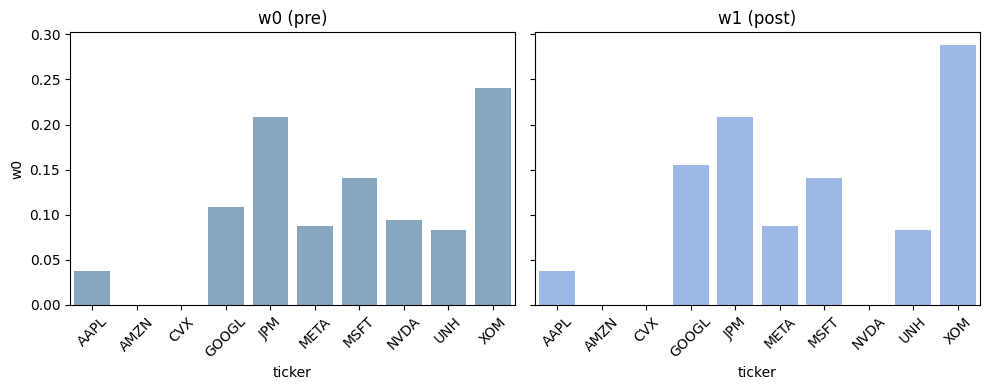

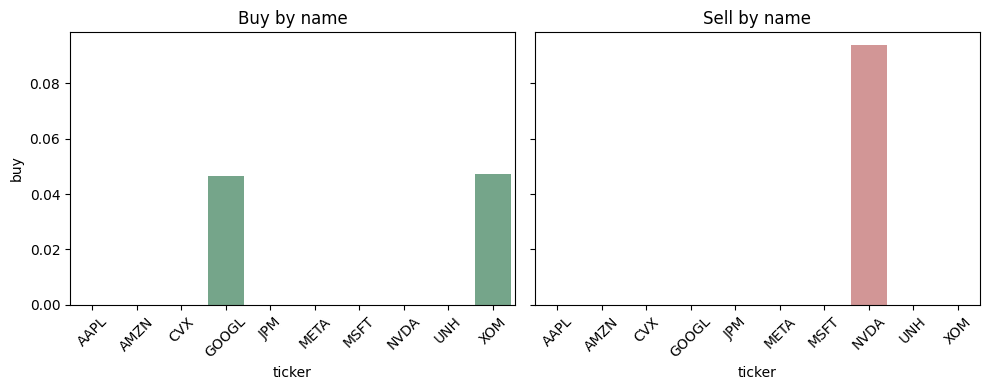

In [15]:
params["name_cap"] = 1
res_reb = solve_rebalance_mean_cvar(ret, sectors, params)
show_rebalance_results(res_reb, sectors)

Rebalance post-portfolio VaR/CVaR
Objective Value: 0.018139
Mean loss: -0.001107
VaR 0.95: 0.014867
CVaR 0.95: 0.022013
Max loss: 0.057937


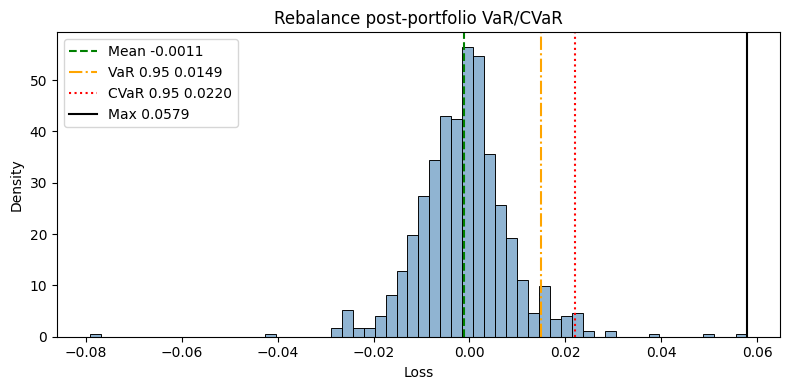

In [16]:
show_portfolio_cvar_rebalance(ret, res_reb, alpha=params["alpha"], title="Rebalance post-portfolio VaR/CVaR")

Baseline Portfolio with same parameters
Objective Value: 0.018340
Mean loss: -0.001107
VaR 0.95: 0.015487
CVaR 0.95: 0.023202
Max loss: 0.058950


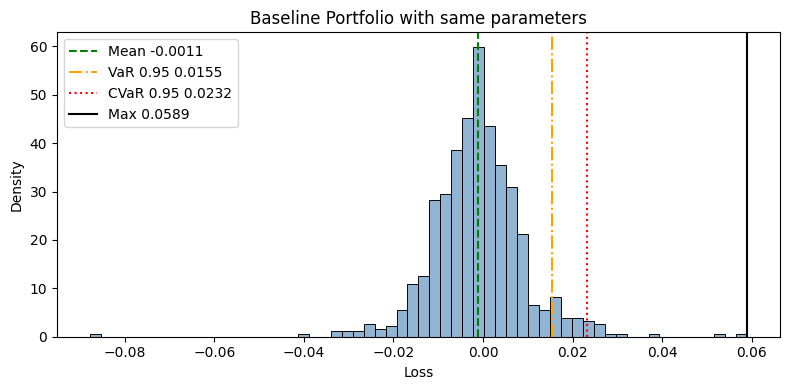

In [17]:
show_portfolio_cvar_baseline(ret, res, alpha=params["alpha"], title = "Baseline Portfolio with same parameters")

## **3.3 Interpretation of Results**
* **Risk/return**: It meets the full-horizon return target (~0.001104/day, expected loss −0.001104). Tail risk tightens to VaR ≈ 0.01487 and CVaR(loss) ≈ 0.02201, so the average loss in the worst 5% of days is about 2.2%.

* **Objective**: The loss-based objective (expected loss + CVaR + costs) is ~0.01814, lower is better given the chosen λ weights.

* **Allocation shifts**: Most names stay steady; the meaningful moves are selling NVDA (0.094 → 0) and buying GOOGL (0.108 → 0.155) and XOM (0.241 → 0.288). Others stay put (JPM, MSFT, META, UNH, AAPL).
Sector mix (post): Energy ~28.8%, Comm Services ~24.3%, Financials ~20.8%, Technology ~17.8%, Healthcare ~8.3%, Consumer Cyclical 0.

* **Turnover/costs**: Turnover is modest (~0.187), reflecting those targeted trades; costs are already baked into the objective. If costs were higher, you’d see less movement; if they were zero, the model could move more.
Caps/feasibility: No name or sector caps bind, so the improvement comes from reallocation rather than constraint relaxation. Budgets remain fully invested pre/post; the CVaR is computed on losses over the whole horizon (w0 before day 375, w1 after).

* **Takeaway**: A single planned rebalance at the midpoint trims tail loss without giving up return, driven by a focused shift away from a higher-tail-loss name (NVDA) toward names with better tail behavior (GOOGL, XOM), all within the existing limits and with modest trading. To traders utilizing this model, it could inform them that NVDA might have hit a period of loss in the second half of the specified three year period.


## **3.4 Comparison to Baseline Model**
* The rebalance run comes out slightly more optimal because it has one extra degree of freedom: it can hold a pre‑k portfolio and then reshape at k to better fit the post‑k return distribution. With modest turnover and costs in the objective, the solver uses that flexibility to nudge risk out of the tail without sacrificing the return floor. The result is a lower tail loss (CVaR) and a better overall risk score, paid for by a small, targeted trade.

* This is not guaranteed to always beat the static baseline. If costs were higher, the post‑k window looked similar to the pre‑k window, or caps were binding, the benefit could shrink or even disappear. Here, the post period is different enough and costs low enough that a single planned rebalance improves the tail profile.

* Overall, if you keep the constraints aligned (same return target, caps, scenarios), and keep costs in the objective; then the rebalance solve will be equal to or better than baseline.

## **3.5 Application**
* For a trader, this model acts like a pre-trade risk check with a clear playbook. Using the historical loss data, it flags which names sit in the worst 5% tail (e.g., NVDA in your run) and which offer milder downside (e.g., GOOGL/XOM), then suggests a single, cost-aware rebalance to tilt away from the riskiest names while holding the same return floor. It quantifies the expected damage on bad days, the VaR/CVaR levels, and the turnover you’d actually trade, so you see the cost of protection versus the reduction in tail loss. In practice, you’d run this before a quarter-end rebalance: if the post-window tail is driven by a few tickers, the model gives a concrete, data-backed shift that lowers expected worst-case loss without blowing up fees or breaching your caps.

# **4 Sensitivity Analysis**
## **4.1 Expanding amount of stock tickers**
Let's expand the model to more than just 10 stock tickers and see its effect on the metrics. Using just rebalance CVaR model. 

In [18]:
params["tickers"] = [
    "AAPL","MSFT","AMZN","GOOGL","META","NVDA","AVGO","CSCO","ADBE","CRM",
    "ORCL","INTC","QCOM","TXN","AMD","AMAT","NOW","PANW","SHOP","INTU",
    "JPM","BAC","GS","MS","WFC","C","BLK","SCHW","BX","AXP",
    "V","MA","PYPL","SPGI","ICE","MCO","CME","AON","CB","TRV",
    "XOM","CVX","COP","SLB","EOG","PSX","MPC","OKE","WMB","HAL",
    "UNH","JNJ","PFE","MRK","ABBV","LLY","TMO","DHR","ABT","BMY",
    "HD","LOW","COST","TGT","WMT","MCD","SBUX","NKE","BKNG","MAR",
    "PG","KO","PEP","CL","KMB","MDLZ","PM","MO","EL","KR",
    "LIN","CAT","DE","HON","GE","UPS","FDX","LMT","BA","RTX",
    "T","VZ","CMCSA","DIS","NFLX","TMUS","CHTR","D","NEE","DUK"
]

tickers = params["tickers"]
px, ret, dropped = load_prices_and_returns(tickers, params["years"], params["use_cached"], params["end_date"])
sectors = ensure_sectors(params["tickers"])

summary = {
    "N": ret.shape[0],
    "S": ret.shape[1],
    "start_date": ret.index.min().date().isoformat(),
    "end_date": ret.index.max().date().isoformat(),
    "dropped": dropped,
    "avg_mean": ret.mean().mean(),
    "avg_std": ret.std().mean(),
    "avg_corr": ret.corr().replace(1.0, np.nan).stack().mean(),
}

display(summary)

sectors = pd.read_csv(DATA_DIR / "sectors.csv").set_index("ticker")["sector"]
missing = [t for t in tickers if t not in sectors.index]
print("Missing sector labels:", missing)

No new sectors fetched.


{'N': 751,
 'S': 100,
 'start_date': '2022-12-09',
 'end_date': '2025-12-08',
 'dropped': [],
 'avg_mean': np.float64(0.0005440737329817466),
 'avg_std': np.float64(0.01742722713093465),
 'avg_corr': np.float64(0.23049325707977197)}

Missing sector labels: []


**Important Note**: if above cell is not running properly, uncomment this to use backup data

In [19]:
# px = pd.read_csv("../Backup Data/big_prices.csv")
# tickers = params["tickers"]

# # If using backup CSVs
# ret = pd.read_csv("../Backup Data/big_returns.csv", index_col=0, parse_dates=True)

# ret = ret[tickers].apply(pd.to_numeric, errors="coerce")
# ret = ret.dropna(how="any")

# sectors = pd.read_csv("../Backup Data/big_sectors.csv", index_col=0)["sector"].reindex(tickers)


# len(ret.columns)

,n_tickers,objective,VaR,CVaR,expected_return,status
0,10,0.022753,0.019238,0.028530,0.001468,ModelStatus.OptimalGlobal
1,20,0.022405,0.018540,0.028334,0.001309,ModelStatus.OptimalGlobal
2,30,0.018880,0.015748,0.023628,0.001157,ModelStatus.OptimalGlobal
3,40,0.012619,0.011632,0.015927,0.000987,ModelStatus.OptimalGlobal
4,50,0.011855,0.010521,0.015029,0.000839,ModelStatus.OptimalGlobal
5,60,0.010467,0.009638,0.013261,0.000710,ModelStatus.OptimalGlobal
6,70,0.009873,0.008927,0.012510,0.000673,ModelStatus.OptimalGlobal
7,80,0.008998,0.008110,0.011421,0.000694,ModelStatus.OptimalGlobal
8,90,0.008978,0.008054,0.011399,0.000705,ModelStatus.OptimalGlobal
9,100,0.008971,0.008067,0.011395,0.000724,ModelStatus.OptimalGlobal


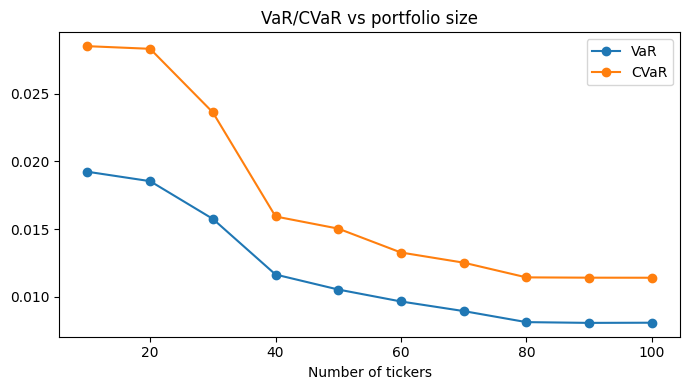

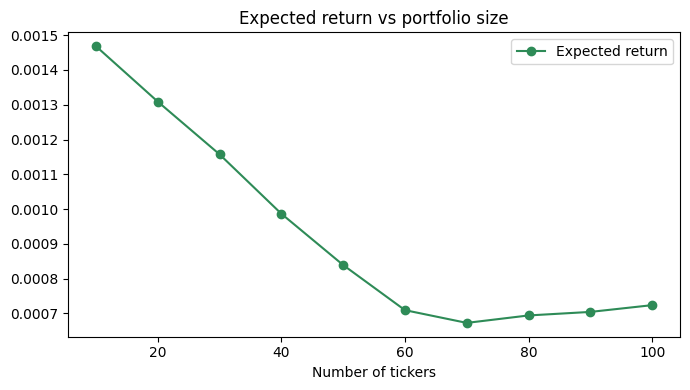

In [20]:
import pandas as pd
import matplotlib.pyplot as plt


tickers_100 = params["tickers"]

records = []
for n in range(10, 101, 10):  
    tickers_n = tickers_100[:n]  

    ret_n = ret[tickers_n]
    sectors_n = sectors.reindex(tickers_n)

    p = params.copy()
    p["tickers"] = tickers_n
    p["return_target"] = "equal_weight_mean"  

    res = solve_rebalance_mean_cvar(ret_n, sectors_n, p)
    records.append({
        "n_tickers": n,
        "objective": res["objective"],
        "VaR": res["VaR"],
        "CVaR": res["CVaR_loss"],
        "expected_return": res["mean_return"],
        "status": res["model_status"],
    })

sens_df = pd.DataFrame(records)
display(sens_df)


plt.figure(figsize=(7,4))
plt.plot(sens_df["n_tickers"], sens_df["VaR"], marker="o", label="VaR")
plt.plot(sens_df["n_tickers"], sens_df["CVaR"], marker="o", label="CVaR")
plt.xlabel("Number of tickers")
plt.title("VaR/CVaR vs portfolio size")
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(7,4))
plt.plot(sens_df["n_tickers"], sens_df["expected_return"], marker="o", color="seagreen", label="Expected return")
plt.xlabel("Number of tickers")
plt.title("Expected return vs portfolio size")
plt.legend()
plt.tight_layout()
plt.show()


### **4.1.1 Results**
* As you add names, you give the optimizer more ways to spread risk. Going from 10 to 100 tickers cuts VaR from ~0.019 to ~0.008 and CVaR from ~0.029 to ~0.011 because it can allocate into additional names with milder tails instead of concentrating in a few. The flip side is a gradual drop in expected return (0.00147 → ~0.00070) under your mean–CVaR objective: with more choices and a CVaR-focused weight, the solver prioritizes tail safety over chasing higher mean. In practice, the extra options lower downside, but because CVaR is weighted in the objective, the portfolio tilts toward safer names, pulling the average return down slightly as diversification increases.

## **4.2 CVaR Weight**
Let's see how changing the weight of CVaR affects the portfolio over the time frame. Using the rebalance model for a more advanced analysis. Setting the return target param to none, and keeping the same params from earlier, just chaning the lambda_cvar value.

,lambda_cvar,objective,VaR,CVaR,expected_return,status
0,0.00,-0.002758,0.087567,0.087567,0.002758,ModelStatus.OptimalGlobal
1,0.05,-0.000596,0.015208,0.021215,0.001744,ModelStatus.OptimalGlobal
2,0.10,0.000280,0.009742,0.013709,0.001212,ModelStatus.OptimalGlobal
3,0.15,0.000981,0.008050,0.012320,0.001020,ModelStatus.OptimalGlobal
4,0.20,0.001636,0.007655,0.011875,0.000924,ModelStatus.OptimalGlobal
5,0.25,0.002267,0.007772,0.011639,0.000857,ModelStatus.OptimalGlobal
6,0.30,0.002884,0.007762,0.011496,0.000807,ModelStatus.OptimalGlobal
7,0.35,0.003498,0.007795,0.011477,0.000798,ModelStatus.OptimalGlobal
8,0.40,0.004111,0.007860,0.011435,0.000772,ModelStatus.OptimalGlobal
9,0.45,0.004720,0.007912,0.011413,0.000755,ModelStatus.OptimalGlobal


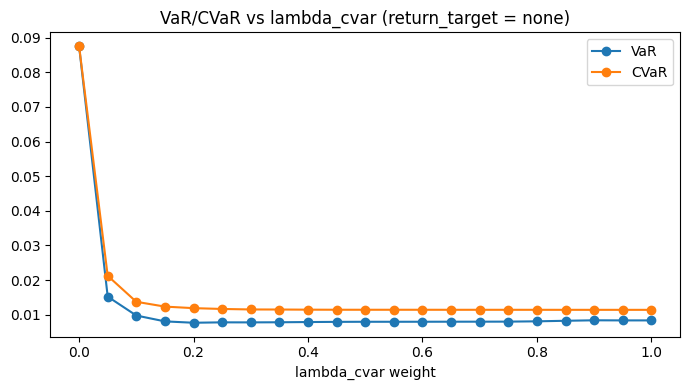

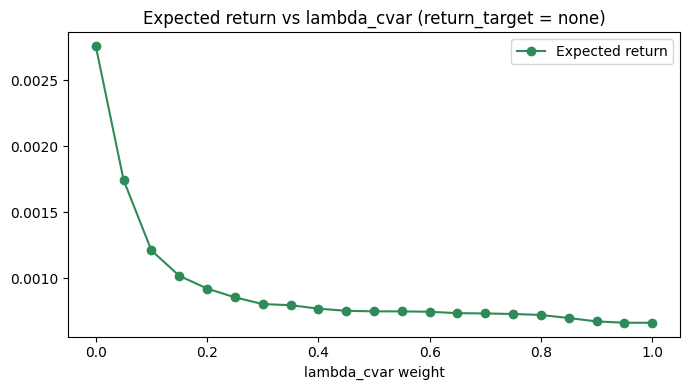

In [21]:
lambda_grid = np.linspace(0.0, 1.0, 21)  
records = []

for lam in lambda_grid:
    p = params.copy()
    p["name_cap"] = 1
    p["lambda_cvar"] = lam
    p["return_target"] = "none"
    res = solve_rebalance_mean_cvar(ret, sectors, p)
    records.append({
        "lambda_cvar": lam,
        "objective": res["objective"],
        "VaR": res["VaR"],
        "CVaR": res["CVaR_loss"],
        "expected_return": res["mean_return"],
        "status": res["model_status"],
    })

sens_df = pd.DataFrame(records)
display(sens_df)


plt.figure(figsize=(7,4))
plt.plot(sens_df["lambda_cvar"], sens_df["VaR"], marker="o", label="VaR")
plt.plot(sens_df["lambda_cvar"], sens_df["CVaR"], marker="o", label="CVaR")
plt.xlabel("lambda_cvar weight")
plt.title("VaR/CVaR vs lambda_cvar (return_target = none)")
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(7,4))
plt.plot(sens_df["lambda_cvar"], sens_df["expected_return"], marker="o", color="seagreen", label="Expected return")
plt.xlabel("lambda_cvar weight")
plt.title("Expected return vs lambda_cvar (return_target = none)")
plt.legend()
plt.tight_layout()
plt.show()


### **4.2.1 Results**
* With 100 names, λ_cvar cleanly acts as your risk dial. Moving λ from 0 to ~0.2–0.3 slashes tail risk: VaR falls from ~0.087 to ~0.0077–0.0079 and CVaR from ~0.0875 to ~0.0115–0.012. Beyond ~0.35 the VaR/CVaR gains are negligible. They flatten around 0.0078–0.0081 and 0.0114. The trade-off is expected return: it drops from ~0.00276 at λ=0 to ~0.0009 by λ≈0.2 and continues down toward ~0.00066 at λ=1. Objective rises as you weight risk more, which is expected with a loss-sign convention. All solves are OptimalGlobal. In practice, λ≈0.2–0.3 captures most of the tail-risk benefit with a manageable hit to return; pushing λ higher pays more in return for marginal extra protection.

* What this can tell us is that it is bad to focus all your energy on either return of CVaR, it has to be balanced. If you have a weight of 0 for CVaR, sure your expected return is very high, but it is also very volatile on it's worse days. If you have a weight of 1 for CVaR, then you see very small returns.

## **4.3 Alpha Level**
How the CVaR confidence level (α) changes tail-risk and return. Using the rebalance model.

,alpha,objective,VaR,CVaR,expected_return,status
0,0.80,0.005402,0.003509,0.006950,0.000789,ModelStatus.OptimalGlobal
1,0.81,0.005543,0.003665,0.007126,0.000786,ModelStatus.OptimalGlobal
2,0.82,0.005691,0.003917,0.007306,0.000769,ModelStatus.OptimalGlobal
3,0.83,0.005839,0.004311,0.007493,0.000781,ModelStatus.OptimalGlobal
4,0.84,0.005991,0.004539,0.007684,0.000783,ModelStatus.OptimalGlobal
5,0.85,0.006153,0.004743,0.007883,0.000768,ModelStatus.OptimalGlobal
6,0.86,0.006323,0.005029,0.008096,0.000770,ModelStatus.OptimalGlobal
7,0.87,0.006507,0.005200,0.008321,0.000749,ModelStatus.OptimalGlobal
8,0.88,0.006707,0.005490,0.008571,0.000752,ModelStatus.OptimalGlobal
9,0.89,0.006919,0.005800,0.008841,0.000767,ModelStatus.OptimalGlobal


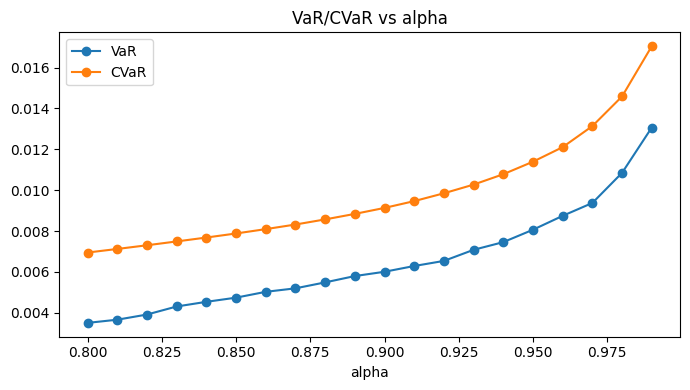

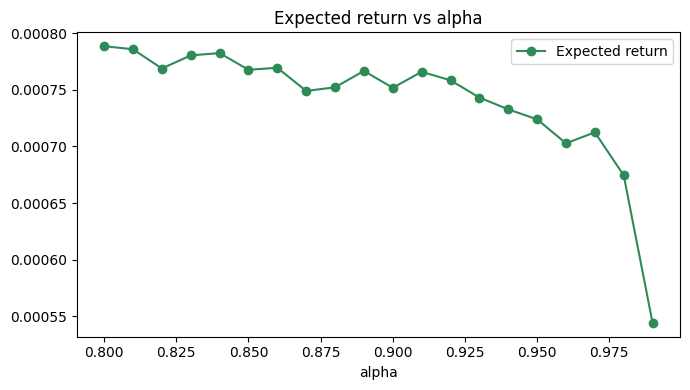

In [22]:
alpha_grid = np.linspace(0.8, 0.99, 20) 
records = []

for a in alpha_grid:
    p = params.copy()
    p["alpha"] = a
    p["return_target"] = "equal_weight_mean"  
    res = solve_rebalance_mean_cvar(ret, sectors, p)
    records.append({
        "alpha": a,
        "objective": res["objective"],
        "VaR": res["VaR"],
        "CVaR": res["CVaR_loss"],
        "expected_return": res["mean_return"],
        "status": res["model_status"],
    })

alpha_df = pd.DataFrame(records)
display(alpha_df)

plt.figure(figsize=(7,4))
plt.plot(alpha_df["alpha"], alpha_df["VaR"], marker="o", label="VaR")
plt.plot(alpha_df["alpha"], alpha_df["CVaR"], marker="o", label="CVaR")
plt.xlabel("alpha")
plt.title("VaR/CVaR vs alpha")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(alpha_df["alpha"], alpha_df["expected_return"], marker="o", color="seagreen", label="Expected return")
plt.xlabel("alpha")
plt.title("Expected return vs alpha")
plt.legend()
plt.tight_layout()
plt.show()


### **4.3.1 Results**
* In this CVaR portfolio, α is your “how deep into the bad days” knob. Raising α from 0.80 to 0.99 tells the model to manage a thinner, more severe tail, so the reported tail losses jump (VaR from ~0.0035 to ~0.013, CVaR from ~0.007 to ~0.017) and the portfolio shifts toward safer names, trimming expected return a bit (≈0.00079 → ≈0.00054). The objective rises because you’re tightening the tail-risk focus. In practice, a mid-range α (e.g., 0.95) is a common compromise; lower α shows milder tails and slightly higher return, higher α shows heavier tails and a more conservative allocation. All runs remained feasible/optimal, so you can choose α based on your risk tolerance.

# **5 Conclusion**
This project stemmed from an interest in the simple mean-based homework problem. After researching and listening to lectures, I decided it would be interesting to use the CVaR framework to answer the main question: how does explicitly controlling tail risk change portfolio construction? To make this project sufficiently complex, it was decided to create a baseline CVaR model and a rebalance CVaR model. From the baseline model, an equal-weight benchmark test was performed, with all weights set to equal values, and the results were compared with those from an unconstrained weight run. It was clear that this extra room helped lower CVaR while still meeting the expected return target that was the same in both portfolios. Then, it was time to compare how this ran against the rebalanced model. The rebalanced model lets users buy and sell stocks on a specific day within a time period. It was found that the rebalance model added flexibility under the same parameters as the baseline model, meaning the objective was either equal to or lower than the baseline model's. An additional sensitivity analysis was conducted to examine the effects of changing certain parameters, with the aim of providing additional context for users of this model. Overall, this project can help provide insights into portfolio CVaR, enabling users to identify which stocks and sectors may be less risky than others. 

# **6 Additional Analysis Ideas**

* **Multiple rebalances**: A natural extension of this work would be to move from the current two stage setting to a multi stage model with several planned rebalances, for example quarterly nodes over the three year horizon. This would require building a scenario tree over time, defining portfolio weights and trade vectors at each rebalance date, carrying wealth forward, and charging transaction costs at every stage. The same CVaR objective could be applied to full horizon losses, while enforcing budget, sector caps, and position limits stage by stage. In practice this becomes a much larger linear program, so it is a good candidate for the ReShop function we learned about in class, which can reuse structure and solutions between related solves. I was not able to implement this version due to its complexity and time constraints, but it would be a very interesting way to see how much additional tail risk reduction is possible when the portfolio can adapt more than once.

* **Alternative risk measures**: Another direction would be to compare CVaR based portfolios to portfolios that are built using alternative risk measures such as downside deviation or a standard mean variance objective. This would highlight the trade off between a tail focused view of risk and a variance focused view, and show how much the weights move when the objective cares more about typical fluctuations versus extreme losses. It would also be interesting to build a combined objective that includes both CVaR and variance with different weights, then see how the portfolio slides along a spectrum from pure tail protection to smooth day to day volatility control. I did not explore these alternatives in this project, but they could provide useful insight into the benefits and costs of choosing one risk measure over another in practice.

* **Modeling parameter uncertainty and robust CVaR**: A further extension would be to make the model more robust to uncertainty in the historical returns that I used as scenarios. In the current setup, I treat the past three years of data as “correct” and optimize CVaR directly on those losses. A robust version could build an uncertainty set around the scenario returns or their probabilities, then choose portfolio weights that perform well under the worst case CVaR within that set. This would likely push the solution toward more diversified and conservative portfolios, and it would connect the project to the robust optimization and chance constraint ideas we discussed in class.
